# Implementation of [Cascaded Fast and Slow Models for Efficient Semantic Code Search](https://arxiv.org/abs/2110.07811)

Due to computational limitations, the datasets have been reduced:

Train size: 10000 (20000 with constructed negative records)

Validation size: 1000

Test size: 1000

Training epochs: 3

MRR: k = 10: 0.574 ; k = 20: 0.605

## Required libraries, functions and classes:

In [ ]:
!pip install transformers --quiet
!pip install livelossplot --quiet
!pip install info-nce-pytorch --quiet

In [ ]:
import datetime
import json
import random
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from traceback import format_exc
from typing import Dict, List, Tuple, Union, Optional

import numpy as np
import torch
import transformers
from google.colab import drive, files
from info_nce import InfoNCE
from livelossplot import PlotLosses
from scipy.spatial.distance import cosine
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from tqdm.notebook import tqdm
from transformers import (RobertaConfig, RobertaForSequenceClassification,
                          RobertaTokenizer)

transformers.logging.set_verbosity_error()

In [ ]:
PROJECT_DIR = "/content/gdrive/MyDrive/ML/Cascaded_models"
DATA_DIR = Path(PROJECT_DIR) / 'data'

PRETRAINED_MODEL_NAME = "microsoft/codebert-base"
PRETRAINED_MODEL_CONFIG = {
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": True,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

LOAD_MODEL = False # Whether to load a previously saved model
model_to_load_path = PROJECT_DIR / Path('model') / Path('saved_model.bin')

SAVE_MODEL = True # Whether to save the trained model
model_to_save_path = PROJECT_DIR / Path('model') / Path('saved_model.bin')

In [ ]:
def init_random_seed(value: int=0):
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [ ]:
def load_model(model_path, device, config, model_class):
    model = model_class(config)
    state_dict = torch.load(model_path, map_location=torch.device(device))
    model.load_state_dict(state_dict)
    return model

In [ ]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [ ]:
@dataclass
class CodexglueData():
    nl_tokens: List[str]
    pl_tokens: List[str]
    idx: int
    label: int

In [ ]:
def _clear(code_tokens: List[str]):
    """Clears code tokens from multiple consecutive spaces."""
    return [" ".join(code_token.split()) for code_token in code_tokens]


def _parse_row(row: str, truncation: Optional[int] = None) -> Optional[CodexglueData]:
    """Parses row of the Codexglue dataset to 'CodexglueData' object.
    If the number of natural language tokens + programming language tokens
    more than 'truncation', returns None"""
    row_json = json.loads(row)
    nl_tokens = row_json["docstring_tokens"]
    pl_tokens = (
        _clear(row_json["code_tokens"])
        if "code_tokens" in row_json.keys()
        else _clear(row_json["function_tokens"])
    )
    if truncation is not None and len(nl_tokens) + len(pl_tokens) > truncation:
        return None
    return CodexglueData(nl_tokens, pl_tokens, row_json["idx"], 1)


def _make_negative_record(i: int, data: List[CodexglueData]) -> CodexglueData:
    """Makes a negative record for 'i'-indexed object of 'data',
    i.e. makes 'CodexglueData' object with random (wrong) code tokens."""
    neg_idx = i
    while neg_idx == i:
        neg_idx = random.randint(0, len(data) - 1)
    nl_tokens = data[i].nl_tokens
    pl_tokens_neg = data[neg_idx].pl_tokens
    return CodexglueData(nl_tokens, pl_tokens_neg, data[i].idx, 0)


def prepare_data(
    filename: Union[str, Path],
    truncation: Optional[int] = None,
    size: Optional[int] = None,
    make_neg_data: bool = False,
) -> List[CodexglueData]:
    """Makes a list of 'CodexglueData' objects from the CodeXGLUE dataset.
    The length of the returned list is restricted by 'size' argument.
    If the number of natural language tokens + programming language tokens
    of a row more than 'truncation', ignores this row.
    If 'make_neg_data' is True, for each record makes a negative record,
    i.e. record with irrelevant code tokens."""
    pos_data = []
    q = 0
    with open(filename) as jsonl_file:
        for row in jsonl_file:
            if make_neg_data and q < 10000:
                q += 1
                continue
            pos_record = _parse_row(row, truncation=truncation)
            if pos_record is not None:
                pos_data.append(pos_record)
            if size is not None and len(pos_data) == size:
                break

    if make_neg_data is True:
        neg_data = []
        for i in range(0, len(pos_data)):
            neg_record = _make_negative_record(i, pos_data)
            neg_data.append(neg_record)
        return pos_data + neg_data

    return pos_data

In [ ]:
class CodeBertDataset(Dataset):
    def __init__(self, tokenizer, data: CodexglueData, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):

        nl_tokens, pl_tokens = self.data[item].nl_tokens, self.data[item].pl_tokens

        nl_encoding = self.tokenizer(
                    text=nl_tokens,
                    add_special_tokens=True,
                    is_split_into_words=True,
                    return_attention_mask=True,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                    )

        pl_encoding = self.tokenizer(
                    text=pl_tokens,
                    add_special_tokens=True,
                    is_split_into_words=True,
                    return_attention_mask=True,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                    )

        pair_encoding = self.tokenizer(
                    text=nl_tokens,
                    text_pair=pl_tokens,
                    add_special_tokens=True,
                    is_split_into_words=True,
                    return_attention_mask=True,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                    )


        return ((nl_encoding['input_ids'].squeeze(), nl_encoding['attention_mask'].squeeze()),
                (pl_encoding['input_ids'].squeeze(), pl_encoding['attention_mask'].squeeze()),
                (pair_encoding['input_ids'].squeeze(), pair_encoding['attention_mask'].squeeze(), torch.tensor(self.data[item].label)))

In [ ]:
def evaluate(model, dataloader, device, show_bar=False):
    model.eval()
    mean_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader) if show_bar else dataloader:
            batch = copy_data_to_device(batch, device)
            loss = compute_loss(model, batch)

            mean_val_loss += float(loss)

        mean_val_loss /= len(dataloader)
            
    return mean_val_loss

In [ ]:
def compute_loss(model, batch):
    """InfoNCE + BCE loss of the batch"""
    nl_input, pl_input, pair_input = batch
    nl_input_ids, nl_attention_mask = nl_input
    pl_input_ids, pl_attention_mask = pl_input
    pair_input_ids, pair_attention_mask, labels = pair_input
    
    nl_hidden_states = model(input_ids=nl_input_ids, attention_mask=nl_attention_mask, output_hidden_states=True).hidden_states
    pl_hidden_states = model(input_ids=pl_input_ids, attention_mask=pl_attention_mask, output_hidden_states=True).hidden_states
    pos_indices = torch.nonzero(labels, as_tuple=True)[0]
    nl_cls = nl_hidden_states[-1][pos_indices, 0, :]
    pl_cls = pl_hidden_states[-1][pos_indices, 0, :]

    bce_loss = model(input_ids=pair_input_ids, attention_mask=pair_attention_mask, labels=labels).loss
    
    if len(pos_indices) < 2:
        return bce_loss
    
    info_nce_loss = InfoNCE()(nl_cls, pl_cls)
    return info_nce_loss + bce_loss

In [ ]:
def train_eval_loop(model, train_dataset, val_dataset, lr=1e-3, epoch_n=100, batch_size_train=32,
                    batch_size_val=32, accumulation_steps=None, device=None, early_stopping_patience=10, weight_decay=0, data_loader_ctor=DataLoader,
                    optimizer_ctor=None, optimizer_parameters=None, lr_scheduler_ctor=None, dataloader_workers_n=0, draw_loss=False, 
                    show_bar=False, show_lr=False, verbose_freq=1, draw_batch_loss=False, draw_accumulated_batch_loss=False):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        if optimizer_parameters is None:
            optimizer = optimizer_ctor(model.parameters(), lr=lr)
        else:
            optimizer = optimizer_ctor(optimizer_parameters)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    if draw_loss:
        liveplot = PlotLosses()
    if draw_batch_loss:
        liveplot_batch = PlotLosses(step_names=f"batch (of size {batch_size_train})\n{len(train_dataset) // batch_size_train} batches total")
    if draw_accumulated_batch_loss:
        assert accumulation_steps is not None
        liveplot_accumulated_batch = PlotLosses(step_names=f"accumulated batch (contains {accumulation_steps} batches of size {batch_size_train})\n{len(train_dataset) // batch_size_train // accumulation_steps} accumulated batches total")
        mean_accumulated_batch_loss = 0

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, num_workers=dataloader_workers_n)

    best_val_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)
    
    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()

            model.train()
            mean_train_loss = 0

            for i, batch in enumerate(tqdm(train_dataloader)) if show_bar else enumerate(train_dataloader):
                batch = copy_data_to_device(batch, device)

                loss = compute_loss(model, batch)

                if accumulation_steps is not None:
                    loss /= accumulation_steps

                loss.backward()

                if draw_batch_loss:
                    liveplot_batch.update({'train loss': loss})
                    liveplot_batch.draw()

                if accumulation_steps is None:
                    optimizer.step()
                    model.zero_grad()
                else:
                    if draw_accumulated_batch_loss:
                        mean_accumulated_batch_loss += float(loss)
                    if (i + 1) % accumulation_steps == 0:
                        optimizer.step()
                        model.zero_grad()
                        if draw_accumulated_batch_loss:
                            liveplot_accumulated_batch.update({'train loss': mean_accumulated_batch_loss})
                            liveplot_accumulated_batch.draw()
                            mean_accumulated_batch_loss = 0


                mean_train_loss += float(loss)

            mean_train_loss /= len(train_dataloader)

            if accumulation_steps is not None:
                mean_train_loss *= accumulation_steps

            mean_val_loss = evaluate(model, val_dataloader, device=device, show_bar=show_bar)
            
            if not (draw_loss or draw_batch_loss or draw_accumulated_batch_loss) and epoch_i % verbose_freq == 0:
                print(f"Epoch {epoch_i}")
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(len(train_dataloader), len(val_dataloader),
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)

            if draw_loss:
                liveplot.update({'mean loss': mean_train_loss, "val_mean loss": mean_val_loss})
                liveplot.draw()

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = deepcopy(model)
                if (not draw_loss) and epoch_i % verbose_freq == 0:
                    print('New best model!')
            elif epoch_i - best_epoch_i == early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break
  
            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_val_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()
            if not (draw_loss or draw_batch_loss or draw_accumulated_batch_loss) and epoch_i % verbose_freq == 0:
                print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_val_loss, best_model

In [ ]:
def compute_cls_vectors(model, dataset: CodeBertDataset, batch_size, device, to_process):
    """Computes CLS vectors of natural or programming language tokens depends on
    'to_process' attribute."""
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    cls_vectors = []
    with torch.no_grad():
        for batch in dataloader:
            batch = copy_data_to_device(batch, device)
            input = batch[0] if to_process == 'nl' else batch[1]         
            input_ids, attention_mask = input
            hidden_states = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True).hidden_states
            cls_tensor = hidden_states[-1][:, 0, :]
            for cls_vector in cls_tensor:
                cls_vectors.append(cls_vector.tolist())

    return cls_vectors

In [ ]:
def compute_knn_indices(vec: List[int], vec_list: List[List[int]], k: int) -> List[int]:
    """Computes indices of k closest vectors of vec_list to vec."""
    distances = []
    for i, v in enumerate(vec_list):
        distances.append((cosine(vec, v), i))
    distances.sort()
    return [distance[1] for distance in distances[:k]]

In [ ]:
def compute_logits(model, dataset: CodeBertDataset, batch_size, indices_dict, device) -> List[Tuple[float, int]]:
    """Computes 'probability' of the first class for 'dataset'.
    Also for each entity returns index defined by 'indices_dict'"""
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    logits_with_indices = []
    with torch.no_grad():
        for batch in dataloader:
            batch = copy_data_to_device(batch, device)
            _, _, pair_input = batch
            pair_input_ids, pair_attention_mask, labels = pair_input
            logits = model(input_ids=pair_input_ids, attention_mask=pair_attention_mask).logits
            for idx, logit in enumerate(logits):
                logits_with_indices.append((logit[1], indices_dict[idx]))

    return logits_with_indices

In [ ]:
def sort_by_logits(
    model,
    data: List[CodexglueData],
    i: int,
    indices: List[int],
    k: int,
    device: torch.device,
) -> List[int]:
    """Computes logits for natural language tokens from i-indexed entity of data
    with every 'indices'-indexed entity. Sort them in decreasing order of model confidence."""
    nl_tokens = data[i].nl_tokens
    candidates_data = []
    indices_dict = {} 
    for can_idx, index in enumerate(indices):
        pl_tokens = data[index].pl_tokens
        candidates_data.append(CodexglueData(nl_tokens, pl_tokens, 0, 0))
        indices_dict[can_idx] = index
    candidates_dataset = CodeBertDataset(tokenizer, candidates_data)
    logits_with_indices = compute_logits(model, candidates_dataset, indices_dict=indices_dict, batch_size=k, device=device)
    return [item[1] for item in sorted(logits_with_indices, reverse=True)]

In [ ]:
def compute_answers(
    model,
    data: List[CodexglueData],
    dataset: CodeBertDataset,
    batch_size: int,
    k: int,
    device: torch.device,
) -> Dict[int, List[int]]:
    """Makes a resulting dictionary that maps the entry's index to a list of
    candidates ordered by descending model confidence."""
    nl_cls_vectors = compute_cls_vectors(model, dataset, batch_size=batch_size, device=device, to_process='nl')    
    pl_cls_vectors = compute_cls_vectors(model, dataset, batch_size=batch_size, device=device, to_process='pl')
    answers = {}
    for i, nl_cls_vector in enumerate(tqdm(nl_cls_vectors)):
        knn_vectors_indices = compute_knn_indices(nl_cls_vector, pl_cls_vectors, k=k)
        sorted_vectors_indices = sort_by_logits(model, data, i, knn_vectors_indices, k, device)
        answers[data[i].idx] = [data[i_].idx for i_ in sorted_vectors_indices]
    return answers

In [ ]:
def compute_mrr(answers: Dict[int, List[int]]) -> float:
    mrr = 0
    for idx, candidates in answers.items():
        if idx not in candidates:
            continue
        mrr += 1 / (candidates.index(idx) + 1)
    return mrr / len(answers)

## Loading the [data](https://github.com/microsoft/CodeXGLUE/blob/main/Text-Code/NL-code-search-Adv/dataset.zip) and construct train, validation and test [CodeBertDataset](#scrollTo=EItm20uOmomb&line=1&uniqifier=1):

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
train_data_path = Path(DATA_DIR) / 'train.jsonl'
valid_data_path = Path(DATA_DIR) / 'valid.jsonl'
test_data_path = Path(DATA_DIR) / 'test.jsonl'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
train_data = prepare_data(train_data_path, truncation=256, size=10000, make_neg_data=True)
valid_data = prepare_data(valid_data_path, size=1000)
test_data = prepare_data(test_data_path, size=1000)

In [ ]:
train_dataset = CodeBertDataset(tokenizer, train_data)
valid_dataset = CodeBertDataset(tokenizer, valid_data)
test_dataset = CodeBertDataset(tokenizer, test_data)

## Loading [CodeBERT model](https://github.com/microsoft/CodeBERT) and fine-tuning:

In [ ]:
if LOAD_MODEL is True:
    config = RobertaConfig.from_dict(PRETRAINED_MODEL_CONFIG)
    model = load_model(model_to_load_path, device, config, RobertaForSequenceClassification)
else:
    model = RobertaForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME)
model.to(device)

In [ ]:
batch_size_train = 5
batch_size_val = 50
batch_size_test = 50

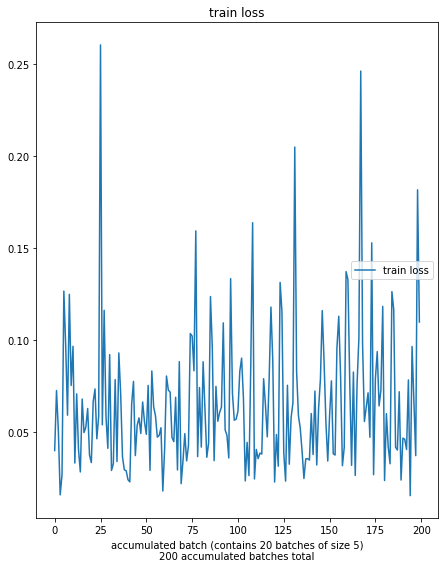

train loss
	train loss       	 (min:    0.016, max:    0.260, cur:    0.110)
New best model!
best val loss:2.1384269


In [ ]:
best_val_loss, best_model = train_eval_loop(model,
                                            train_dataset,
                                            valid_dataset,
                                            epoch_n=1,
                                            lr=2e-5,
                                            batch_size_train=batch_size_train,
                                            batch_size_val=batch_size_val,
                                            accumulation_steps=20,
                                            early_stopping_patience=1,
                                            optimizer_ctor=AdamW,
                                            lr_scheduler_ctor=None,
                                            dataloader_workers_n=0,
                                            draw_loss=False,
                                            show_bar=False,
                                            draw_accumulated_batch_loss=True)

print(f"best val loss:{best_val_loss:.7f}")

## Compute top K aswers for test data for MRR:

In [ ]:
answers = compute_answers(best_model, test_data, test_dataset, batch_size_test, 20, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
mrr = compute_mrr(answers)
print(mrr)

0.6046135905760905


## Save the model and the answer file:

In [ ]:
if SAVE_MODEL is True:
    torch.save(best_model.state_dict(), model_to_save_path)

with open('answers.json', 'w') as f:
    json.dump(answers, f)
    files.download('answers.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>